# Chain-based sequence propagation in conductance-based LIF network

Demo of stable sequence propagation where strength of inhibitory feedback controls propagation speed.

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import sys

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.sparse import csc_matrix
from scipy.stats import linregress

from aux import Generic
from disp import set_font_size, set_color, set_n_x_ticks
from ntwk import LIFNtwkG, join_w

cc = np.concatenate

# PARAMS
## MODEL
M = {
    # E membrane dynamics
    'C_M_E': 1e-6, 'G_L_E': .1e-3, 'E_L_E': -0.05, 'V_TH_E': -0.036, 'V_R_E': -0.05, 'T_R_E': 0.002,
    # E architecture
    'N_E': 6000, 'N_X': 14, 'DX': .035,  # total E cells and chain params
    'W_E_E': .055e-3, 'W_MIN_E_E': .001e-4, 'L_E_E_F': 0.03,  # feed forward chain cxns
    'W_E_A': .0575e-3,  # adaptation (represented by inhibitory autapses)
    
    # I membrane dynamics
    'C_M_I': 1e-6, 'G_L_I': .2e-3, 'E_L_I': -0.06, 'V_TH_I': -0.05, 'V_R_I': -0.06, 'T_R_I': 0.002,
    # I architecture
    'N_I': 1500, 'P_I_E': .5, 'P_E_I': .5, 'W_I_E': 2e-6, 'W_E_I': .4e-6,  # interactions w E cells
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002,
    'E_A': -0.1, 'T_A': 0.01,  # adaptation 
}

## SMLN
S = {
    'RNG_SEED': 0, 'DT': 0.0005, 'D_SMLN': 1,
    'TRG': {'T': 0.05, 'A': 1e-4, 'R': 0.001, 'D': 0.005, 'X': 0},
    'NOISE': 0,  #.2e-6,
}

print('TAU_M_E = {:.1f} ms'.format(M['C_M_E']/M['G_L_E'] * 1e3))
print('TAU_M_I = {:.1f} ms'.format(M['C_M_I']/M['G_L_I'] * 1e3))

TAU_M_E = 10.0 ms
TAU_M_I = 5.0 ms


$\tau^m_E = 10$ ms, $\tau^m_I = 5$ ms, $\tau_E = 2$ ms, $\tau_I = 2$ ms

Network construction

In [2]:
# plot func
def get_idxs_nearest(x_seq, x, nearest):
    """
    Get ordered idxs of place fields nearest to a sequence of xs.
    """
    idxs = []
    
    for x_ in x_seq:
        # get dists of all xs in x_seq to x
        dx = x - x_
        
        # add idxs of closest neurons to list
        idxs_ = list(np.abs(dx).argsort()[:nearest])
        idxs.extend(idxs_)
        
    return idxs

# connectivity funcs
def assign_x(dx, n_x, n, randomize):
    
    # number of layers
    n_l = int(round(n/n_x))
    
    # cells per layer
    n_xs = np.array([len(_) for _ in np.array_split(np.arange(n), n_l)])

    # interleave layer counts to prevent heavier layers bunching at start
    idx_c = np.nan * np.zeros(n_l)

    for n_x_ in np.unique(n_xs):
        mask = n_xs == n_x_
        idx_c[mask] = np.linspace(0, 1, mask.sum()+2)[1:-1]
    n_xs = n_xs[np.argsort(idx_c)]

    # assign x positions
    x = cc([np.repeat(dx*x_ctr, n_xs[x_ctr]) for x_ctr in range(len(n_xs))])
    
    if randomize:
        x = x[np.random.permutation(n)]
        
    return x

def make_w_e_e(x, m):
    """Make E-E weight mat w/ weight increasing w/ proxim."""
    n_e = m['N_E']
    
    # build distance matrix
    dx = np.tile(x[:, None], (1, n_e)) - np.tile(x[None, :], (n_e, 1))
    
    # build weight matrix
    ## decrease weights as squared exp of dist
    w = np.zeros(dx.shape)
    mask_f = dx >= 0  # forward cxns
    w[mask_f] = m['W_E_E'] * np.exp(-dx[mask_f]**2/(2*m['L_E_E_F']**2))
    ## set all weights below min weight th to 0
    w[w < m['W_MIN_E_E']] = 0
    
    return w

def make_w_i_e(m):
    """
    Make random E->I weight matrix.
    """
    n_i = m['N_I']
    n_e = m['N_E']
    
    # build weight matrix
    w_i_e = m['W_I_E'] * (np.random.rand(n_i, n_e) < m['P_I_E']).astype(float)
    return w_i_e
    
def make_w_e_i(m):
    """
    Make random I->E weight matrix.
    """
    n_e = m['N_E']
    n_i = m['N_I']
    
    # build weight matrix
    w_e_i = m['W_E_I'] * (np.random.rand(n_e, n_i) < m['P_E_I']).astype(float)
    return w_e_i

def make_w_e_i_zoned(m, x, zone):
    """
    Make zoned I->E weight matrix.
    """
    n_e = m['N_E']
    n_i = m['N_I']
    
    # build weight matrix
    w_e_i = m['W_E_I'] * (np.random.rand(n_e, n_i) < m['P_E_I']).astype(float)
    
    ## zero all inh feedback outside of control zones
    mask = np.zeros(m['N_E'], dtype=bool)
    
    for zone_ in zone:
        mask[(zone_[0] <= x[:m['N_E']]) & (x[:m['N_E']] < zone_[1])] = True
    
    w_e_i[~mask, :] = 0.
    
    return w_e_i

def build_ntwk(m, s, e_i_zone=None):
    """
    Construct a network object from the model and
    simulation params.
    """
    np.random.seed(s['RNG_SEED'])
    
    # set membrane properties
    n = m['N_E'] + m['N_I']
    
    c_m = cc(
        [np.repeat(m['C_M_E'], m['N_E']), np.repeat(m['C_M_I'], m['N_I'])])
    g_l = cc(
        [np.repeat(m['G_L_E'], m['N_E']), np.repeat(m['G_L_I'], m['N_I'])])
    e_l = cc(
        [np.repeat(m['E_L_E'], m['N_E']), np.repeat(m['E_L_I'], m['N_I'])])
    v_th = cc(
        [np.repeat(m['V_TH_E'], m['N_E']), np.repeat(m['V_TH_I'], m['N_I'])])
    v_r = cc(
        [np.repeat(m['V_R_E'], m['N_E']), np.repeat(m['V_R_I'], m['N_I'])])
    t_r = cc(
        [np.repeat(m['T_R_E'], m['N_E']), np.repeat(m['T_R_I'], m['N_I'])])
    
    # assign chain positions (x) to E cells
    x_e = assign_x(m['DX'], m['N_X'], m['N_E'], randomize=True)
    x = cc([x_e, np.nan * np.zeros(m['N_I'])])
    
    w_u = {'E': np.zeros((m['N_E'] + m['N_I'], 0))}  # no upstream spike inputs
    
    # make rcr ws
    targs_r = cc([np.repeat('E', m['N_E']), np.repeat('I', m['N_I'])])
    
    w_e_e = make_w_e_e(x[:m['N_E']], m)
    w_i_e = make_w_i_e(m)
    
    if e_i_zone is None:
        w_e_i = make_w_e_i(m)
    else:
        w_e_i = make_w_e_i_zoned(m, x, e_i_zone)
    
    w_e_a = m['W_E_A'] * np.eye(m['N_E'])
    
    w_r_temp = {
        'E': {('E', 'E'): w_e_e, ('I', 'E'): w_i_e},
        'I': {('E', 'I'): w_e_i},
        'A': {('E', 'E'): w_e_a},
    }
    
    w_r = join_w(targs_r, targs_r, w_r_temp)
    
    # make ntwk
    ntwk = LIFNtwkG(
        c_m=c_m,
        g_l=g_l,
        e_l=e_l,
        v_th=v_th,
        v_r=v_r,
        t_r=t_r,
        e_s={'E': m['E_E'], 'I': m['E_I'], 'A': m['E_A']},
        t_s={'E': m['T_E'], 'I': m['T_I'], 'A': m['T_A']},
        w_r=w_r,
        w_u=w_u)
    
    ntwk.x = x
    
    ntwk.types_r = targs_r
    
    ntwk.n_e = m['N_E']
    ntwk.n_i = m['N_I']
    ntwk.n = m['N_E'] + m['N_I']
    
    return ntwk

def i_ext_trg(t, ntwk, m, s):
    """
    Add replay trigger to external current stim.
    """
    i_ext = np.zeros((len(t), m['N_E'] + m['N_I']))
    
    # get mask over cells to trigger to induce replay
    ## compute distances to trigger center
    dx = ntwk.x - s['TRG']['X']

    ## get mask
    trg_mask = (np.abs(dx) < s['TRG']['R']) & (ntwk.types_r == 'E')

    ## get time mask
    t_mask = (s['TRG']['T'] <= t) \
        & (t < (s['TRG']['T'] + s['TRG']['D']))

    ## add in external trigger
    i_ext[np.outer(t_mask, trg_mask)] = s['TRG']['A']

    return i_ext

Plotting

In [3]:
def get_x_pulse(rslt, t_wdw):
    """Get x position vs time of propagating pulse."""
    t = rslt.t
    x_pulse = np.nan * np.zeros(len(t))
    dt_wdw = int(np.ceil(t_wdw/rslt.s['DT']/2)*2)
    
    x_tiled = np.tile(rslt.ntwk.x[None, :], (dt_wdw+1, 1))
    
    for ct, t_ in enumerate(t):
        t_mask = ((t_-t_wdw/2) <= t) & (t < (t_+t_wdw/2))
        spk_mask = rslt.spks[t_mask, :]
        if spk_mask.sum() > 1:
            x_pulse[ct] = np.nanmedian(x_tiled[:t_mask.sum()][spk_mask.astype(bool)])
        else:
            x_pulse[ct] = np.nan
        
    # calc slope and offset
    valid = ~np.isnan(x_pulse)
    a, b = linregress(t[valid], x_pulse[valid])[:2]
    
    return x_pulse, a, b

def qk_plt(rslts, rslt_c, epoch=None, xpl=-1):
    """Make quick raster, pulse location, firing rate, and spike order plots."""
    # make plots
    x_raster = np.linspace(0, np.nanmax(rslts[0].ntwk.x), 30)

    colors=np.zeros(len(x_raster))
    cmap='inferno'
    nearest=2
    smoothness=4
    fig_size=(10, 20)
    start = epoch[0]
    end = epoch[1]

    fig, axs = plt.subplots(4, 1, figsize=fig_size, tight_layout=True)

    for rslt, c in zip(rslts, rslt_c):
        # get ordered idxs of Es to plot
        e_mask = rslt.ntwk.types_r == 'E'
        x = rslt.ntwk.x[e_mask]

        ## loop through (x, y) pairs and add idxs of nearest Es
        e_idxs = get_idxs_nearest(x_raster, x, nearest) 

        # get all spks for selected Es
        spks_e_chosen = rslt.spks[:, e_idxs]

        t_mask = (start <= rslt.t) & (rslt.t < end)
        t_start = rslt.t[t_mask][0]

        spk_t_idxs, es = spks_e_chosen[t_mask].nonzero()
        spk_ts = spk_t_idxs * rslt.s['DT'] + t_start

        ## spks
        axs[0].scatter(spk_ts, es, c=c, s=15, vmin=0, vmax=1, cmap=cmap)

    axs[0].set_xlim(start, end)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Cell')
    axs[0].set_title('Sorted selected cells')

    # plot pulse x-position vs time
    labels = []
    for rslt, c in zip(rslts, rslt_c):
        x_pulse, a, b = get_x_pulse(rslt, t_wdw=0.002)
        
        axs[1].plot(rslt.t, x_pulse, c=c, lw=2)
        
        if b/a < 0:
            labels.append('{0:.3f}(t - {1:.3f})'.format(a, -b/a))
        else:
            labels.append('{0:.3f}(t + {1:.3f})'.format(a, b/a))
        
    axs[1].set_xlim(start, end)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('x (m)')
    axs[1].set_title('Pulse location')
    axs[1].legend(labels=labels, loc='lower right')
    
    for ax in axs[:2]:
        ax.grid()
        set_font_size(ax, 16)
    
    # plot example result ppln frs
    rslt = rslts[xpl]

    # Es
    ## get spks
    spks_e = rslt.spks[:, :rslt.m['N_E']]

    ## raster
    t_idxs_spks_e, nrn_spks_e = spks_e.nonzero()
    t_spks_e = t_idxs_spks_e * rslt.dt

    axs[2].scatter(t_spks_e, nrn_spks_e, s=2, c='k')

    # population firing rate
    axs[3].plot(rslt.t, smooth(spks_e.sum(axis=1) / (rslt.dt * rslt.m['N_E']), smoothness), c='k', lw=3)
    axs[3].set_xlabel('Time (s)')
    axs[3].set_ylabel('E spike rate (Hz)')
    axs[3].set_title('Population spike rates')

    # Is
    # get spks
    spks_i = rslt.spks[:, -rslt.m['N_I']:]

    # raster
    t_idxs_spks_i, nrn_spks_i = spks_i.nonzero()
    t_spks_i = t_idxs_spks_i * rslt.dt

    axs[2].scatter(t_spks_i, -(1 + nrn_spks_i), s=2, c='r')
    axs[2].set_yticks([-rslt.m['N_I']/2, rslt.m['N_E']/2])
    axs[2].set_yticklabels(['I', 'E'])
    axs[2].set_xlabel('Time (s)')
    axs[2].set_title('Full raster')

    for tick_label, color in zip(axs[2].get_yticklabels(), ['r', 'k']):
        tick_label.set_color(color)

    # inh population average
    ax_3_twin = axs[3].twinx()
    ax_3_twin.plot(rslt.t, smooth(spks_i.sum(axis=1) / (rslt.dt * rslt.m['N_I']), smoothness), c='r', lw=2)
    ax_3_twin.set_ylabel('I spike rate (Hz)')

    axs[3].set_zorder(ax_3_twin.get_zorder() + 1)
    axs[3].patch.set_visible(False)

    set_color(ax_3_twin, 'r')

    for ax in list(axs[1:]) + [ax_3_twin]:
        ax.set_xlim(start, end)
        set_font_size(ax, 16)
        
    # spike order
    cmap='gist_rainbow'
    sct_sz=25

    fig, ax = plt.subplots(1, 1, figsize=(12, 3), tight_layout=True)

    ## detection wdw
    t_mask = (start <= rslt.t) & (rslt.t < end)

    e_mask = rslt.ntwk.types_r == 'E'

    x_e = rslt.ntwk.x[e_mask]
    y_e = np.random.normal(0, .1, len(x_e))

    ## E spk cts within detection window
    spks_wdw_e = rslt.spks[t_mask][:, e_mask]
    spk_ct_wdw_e = spks_wdw_e.sum(0)

    ## discrete colormap for showing spk cts
    c_map_tmp = plt.cm.jet
    c_map_list = [c_map_tmp(i) for i in range(c_map_tmp.N)]
    c_map_list[0] = (0., 0., 0., 1.)
    c_map = c_map_tmp.from_list('spk_ct', c_map_list, c_map_tmp.N)

    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    norm = mpl.colors.BoundaryNorm(bounds, c_map.N)

    # E spiking order
    if not np.any(spk_ct_wdw_e):
        raise Exception('No spks')

    ## black bkgd for all Es
    ax.scatter(x_e, y_e, c='k', s=25, zorder=-1)

    ## color Es according to timing of first spike
    spk_mask = spk_ct_wdw_e > 0
    spk_order = np.argmax(spks_wdw_e[:, spk_mask], 0)
    spk_order = np.argsort(spk_order).argsort()

    v_min = spk_order.min()
    v_max = spk_order.max()

    im = ax.scatter(
        x_e[spk_mask], y_e[spk_mask], c=spk_order, s=sct_sz,
        vmin=v_min, vmax=v_max, cmap=cmap, zorder=0)

    divider = make_axes_locatable(ax)
    c_ax = divider.append_axes('right', size='5%', pad=0.05)

    cb = fig.colorbar(im, cax=c_ax, ticks=[v_min, v_max])
    cb.set_ticklabels(['first spk', 'last spk'])

    ax.set_aspect('equal')

    ax.set_xlabel('Chain position (a.u.)')
    ax.yaxis.set_visible(False)
    ax.set_title('Spikes from {} to {} s.'.format(*epoch))

    for ax_ in [ax, cb.ax]:
        set_font_size(ax_, 14)

    ax.set_facecolor((.7, .7, .7))
    
    
def bk_zn_plt(rslts, rslt_c, e_i_zone, e_i_zone_t, epoch):
    # make plots
    x_raster = np.linspace(0, np.nanmax(rslts[0].ntwk.x), 30)

    colors=np.zeros(len(x_raster))
    cmap='inferno'
    nearest=2
    smoothness=4
    fig_size=(15, 15)
    start = epoch[0]
    end = epoch[1]

    fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)

    # plot pulse x-position vs time
    labels = []
    for rslt, c in zip(rslts, rslt_c):
        x_pulse, a, b = get_x_pulse(rslt, t_wdw=0.002)
        
        ax.plot(rslt.t, x_pulse, c=c, lw=2)
        
        if b/a < 0:
            labels.append('{0:.3f}(t - {1:.3f})'.format(a, -b/a))
        else:
            labels.append('{0:.3f}(t + {1:.3f})'.format(a, b/a))
        
    ax.set_xlim(start, end)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('x (m)')
    ax.set_title('Pulse location')
    ax.legend(labels=labels, loc='lower right')
    
    for t_1, t_2 in e_i_zone_t:
        ax.axvspan(t_1, t_2, color='b', alpha=0.1)
    for x_1, x_2 in e_i_zone:
        ax.axhspan(x_1, x_2, color='r', alpha=0.1)
    
    ax.grid()
    set_font_size(ax, 16)

# Sequence correction via braking zones

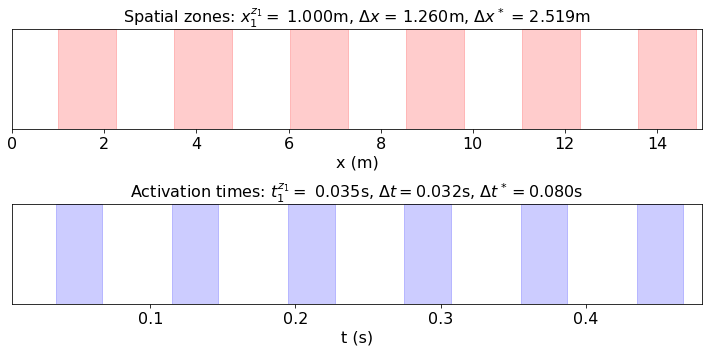

In [4]:
# set up control zones and control input signal
x_0 = [0, .525, 1.05, 1.4]  # .07  # 0.105  # 1.05

V_0 = 34.99
V_1 = 21.67
T_0 = 0.05 - .015
X_0 = 0 + 1
DEL_T_S = .08
DEL_T = DEL_T_S * .4
DEL_X_S = DEL_T_S * V_0 * .9  # scale factor must be < 1
DEL_X = DEL_X_S/2

T_LIM = (0, .5)
X_LIM = (0, 15)

T_1 = np.arange(T_0, T_LIM[1], DEL_T_S)
T_2 = T_1 + DEL_T
X_1 = np.arange(X_0, X_LIM[1], DEL_X_S)
X_2 = X_1 + DEL_X

x = assign_x(M['DX'], M['N_X'], M['N_E'], randomize=True)

e_i_zone = list(zip(X_1, X_2))
e_i_zone_t = list(zip(T_1, T_2))

fig, axs = plt.subplots(2, 1, figsize=(10, 5), tight_layout=True)
for e_i_zone_ in e_i_zone:
    axs[0].axvspan(e_i_zone_[0], e_i_zone_[1],  color='r', alpha=0.2)
    
axs[0].set_xlim(0, np.nanmax(x))
axs[0].set_xlabel('x (m)')
axs[0].yaxis.set_visible(False)
title = 'Spatial zones: ' \
    + '$x_1^{z_1}' + '=$ {0:.3f}m, $\Delta x $ = {1:.3f}m, $\Delta x^*$ = {2:.3f}m'.format(X_0, DEL_X, DEL_X_S)
axs[0].set_title(title)
    
for e_i_zone_t_ in e_i_zone_t:
    axs[1].axvspan(*e_i_zone_t_, color='b', alpha=0.2)
axs[1].set_xlim(0.005, .48)
axs[1].set_xlabel('t (s)')
axs[1].yaxis.set_visible(False)
title = 'Activation times: ' \
    + '$t_1^{z_1}' + '=$ {0:.3f}s, $\Delta t =${1:.3f}s, $\Delta t^* =${2:.3f}s'.format(T_0, DEL_T, DEL_T_S)
axs[1].set_title(title)

for ax in axs:
    set_font_size(ax, 16)

In [5]:
m = copy(M)
s = copy(S)

i_ext_i_hold = -2e-6

t2e_i_zone_t = [e_i_zone_t, e_i_zone_t, e_i_zone_t, e_i_zone_t]

rslts = []
rslt_c = [(0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 0)]

for czone, e_i_zone_t in enumerate(t2e_i_zone_t, 1):
    print('Running smln {}...'.format(czone))
    
    t = np.arange(0, s['D_SMLN'], s['DT'])
    s['TRG']['X'] = x_0[czone-1]
    
    ntwk = build_ntwk(m, s, e_i_zone=e_i_zone)

    i_ext = np.zeros((len(t), m['N_E'] + m['N_I']))
    
    # add replay trigger
    i_ext += i_ext_trg(t, ntwk, m, s)
    
    # add ext drive to INH nrns
    i_ext_i = i_ext_i_hold * np.ones((len(t), m['N_I']))
    
    for e_i_zone_t_ in e_i_zone_t:
        mt = (e_i_zone_t_[0] <= t) & (t < e_i_zone_t_[1])
        i_ext_i[mt, :] = 0
    
    i_ext[:, -m['N_I']:] = i_ext_i

    # run smln
    clamp = Generic(
        v={0: cc([np.repeat(m['E_L_E'], m['N_E']), np.repeat(m['E_L_I'], m['N_I'])])}, spk={})
    rslt = ntwk.run(i_ext=i_ext, clamp=clamp, dt=s['DT'])
    
    # consolidate smln rslt
    rslt.ntwk = ntwk
    rslt.trg = s['TRG']
    
    rslt.m = m
    rslt.s = s
    
    rslts.append(rslt)

Running smln 1...
Running smln 2...
Running smln 3...
Running smln 4...


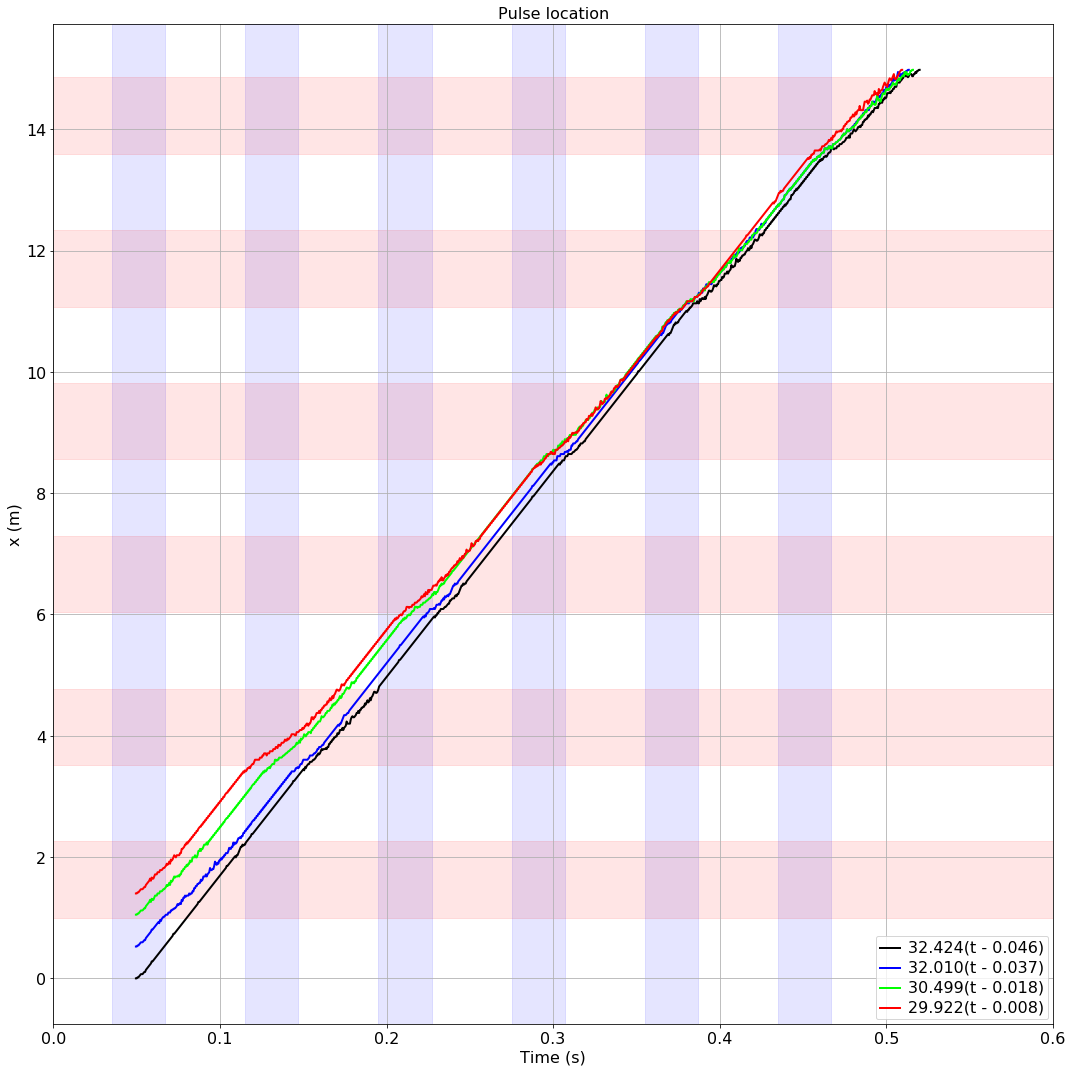

In [6]:
bk_zn_plt(rslts, rslt_c, e_i_zone, e_i_zone_t, epoch=(0, .6))

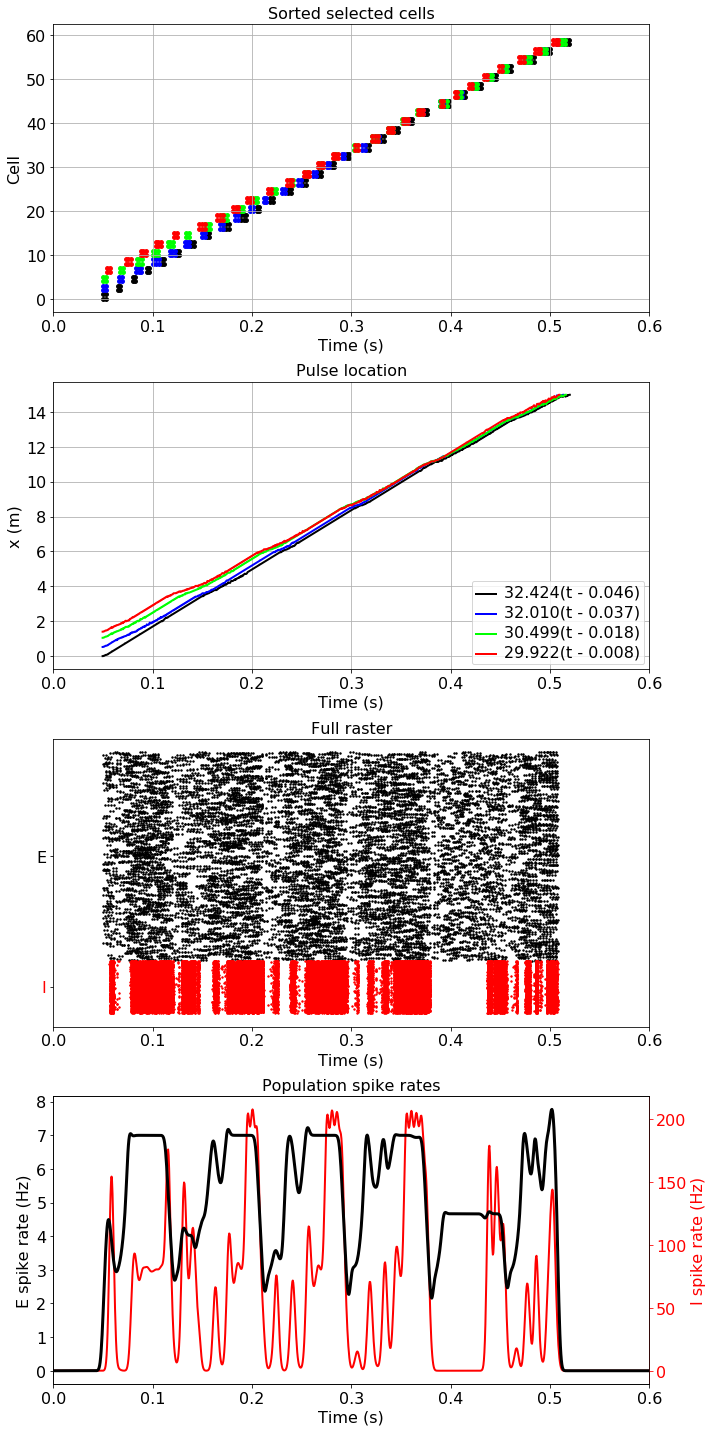

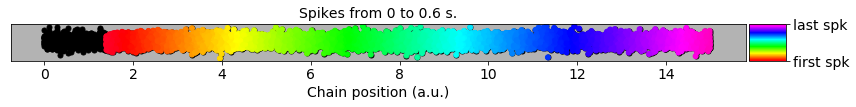

In [7]:
qk_plt(rslts, rslt_c, epoch=(0, .6))

No disinhibition

In [8]:
m = copy(M)
s = copy(S)

i_ext_i_hold = -2e-6

t2e_i_zone_t = [e_i_zone_t, e_i_zone_t, e_i_zone_t]

rslts = []
rslt_c = [(0, 0, 0), (0, 0, 1), (0, 1, 0)]

for czone, e_i_zone_t in enumerate(t2e_i_zone_t, 1):
    print('Running smln {}...'.format(czone))
    
    t = np.arange(0, s['D_SMLN'], s['DT'])
    s['TRG']['X'] = x_0[czone-1]
    
    ntwk = build_ntwk(m, s, e_i_zone=e_i_zone)

    i_ext = np.zeros((len(t), m['N_E'] + m['N_I']))
    
    # add replay trigger
    i_ext += i_ext_trg(t, ntwk, m, s)
    
    # add ext drive to INH nrns
    i_ext_i = i_ext_i_hold * np.ones((len(t), m['N_I']))
    
    for e_i_zone_t_ in e_i_zone_t:
        mt = (e_i_zone_t_[0] <= t) & (t < e_i_zone_t_[1])
        i_ext_i[mt, :] = 0
    
    #i_ext[:, -m['N_I']:] = i_ext_i

    # run smln
    clamp = Generic(
        v={0: cc([np.repeat(m['E_L_E'], m['N_E']), np.repeat(m['E_L_I'], m['N_I'])])}, spk={})
    rslt = ntwk.run(i_ext=i_ext, clamp=clamp, dt=s['DT'])
    
    # consolidate smln rslt
    rslt.ntwk = ntwk
    rslt.trg = s['TRG']
    
    rslt.m = m
    rslt.s = s
    
    rslts.append(rslt)

Running smln 1...
Running smln 2...
Running smln 3...


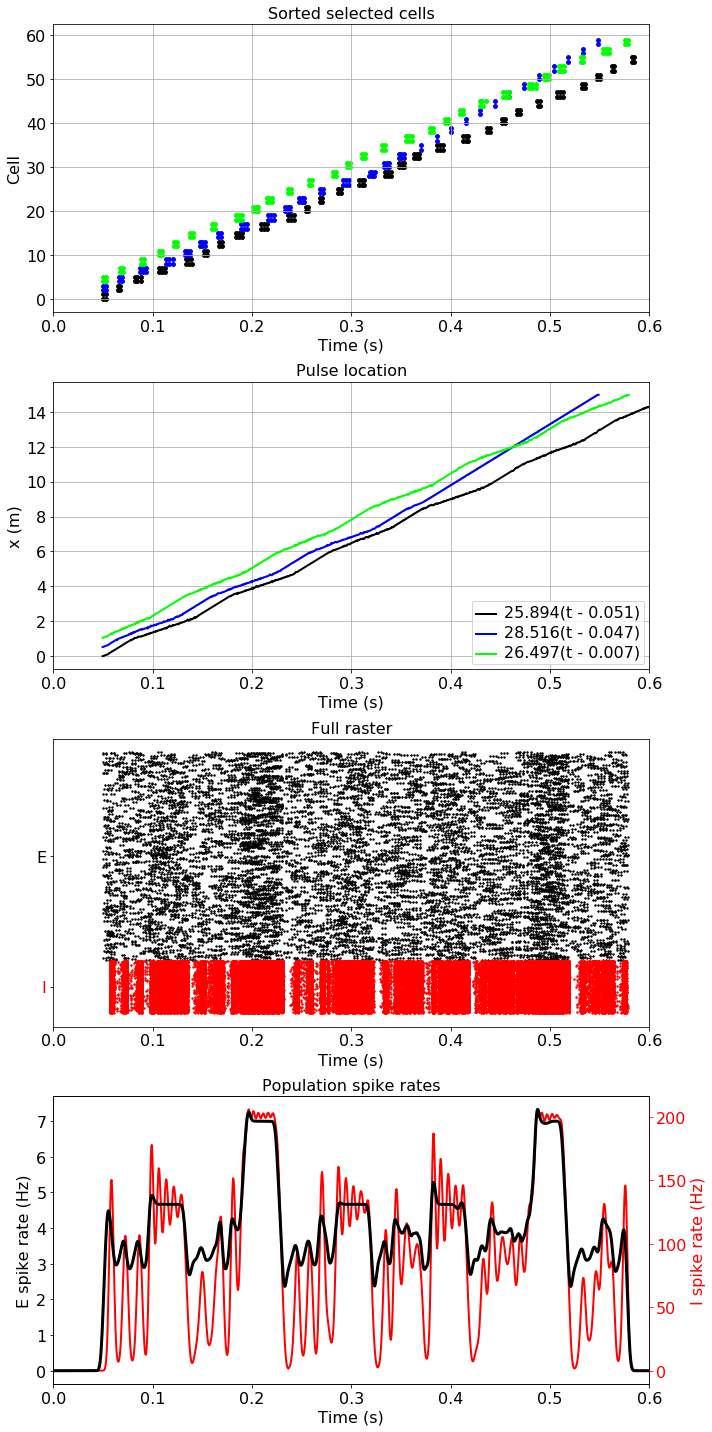

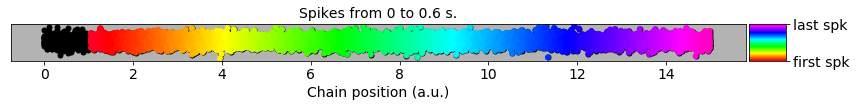

In [9]:
qk_plt(rslts, rslt_c, epoch=(0, .6))

Constant disinhibition

In [10]:
m = copy(M)
s = copy(S)

i_ext_i_hold = -2e-6

t2e_i_zone_t = [e_i_zone_t, e_i_zone_t, e_i_zone_t]

rslts = []
rslt_c = [(0, 0, 0), (0, 0, 1), (0, 1, 0)]

for czone, e_i_zone_t in enumerate(t2e_i_zone_t, 1):
    print('Running smln {}...'.format(czone))
    
    t = np.arange(0, s['D_SMLN'], s['DT'])
    s['TRG']['X'] = x_0[czone-1]
    
    ntwk = build_ntwk(m, s, e_i_zone=e_i_zone)

    i_ext = np.zeros((len(t), m['N_E'] + m['N_I']))
    
    # add replay trigger
    i_ext += i_ext_trg(t, ntwk, m, s)
    
    # add ext drive to INH nrns
    i_ext_i = i_ext_i_hold * np.ones((len(t), m['N_I']))
    
    for e_i_zone_t_ in e_i_zone_t:
        mt = (e_i_zone_t_[0] <= t) & (t < e_i_zone_t_[1])
        i_ext_i[mt, :] = 0
    
    i_ext[:, -m['N_I']:] = -2e-6

    # run smln
    clamp = Generic(
        v={0: cc([np.repeat(m['E_L_E'], m['N_E']), np.repeat(m['E_L_I'], m['N_I'])])}, spk={})
    rslt = ntwk.run(i_ext=i_ext, clamp=clamp, dt=s['DT'])
    
    # consolidate smln rslt
    rslt.ntwk = ntwk
    rslt.trg = s['TRG']
    
    rslt.m = m
    rslt.s = s
    
    rslts.append(rslt)

Running smln 1...
Running smln 2...
Running smln 3...


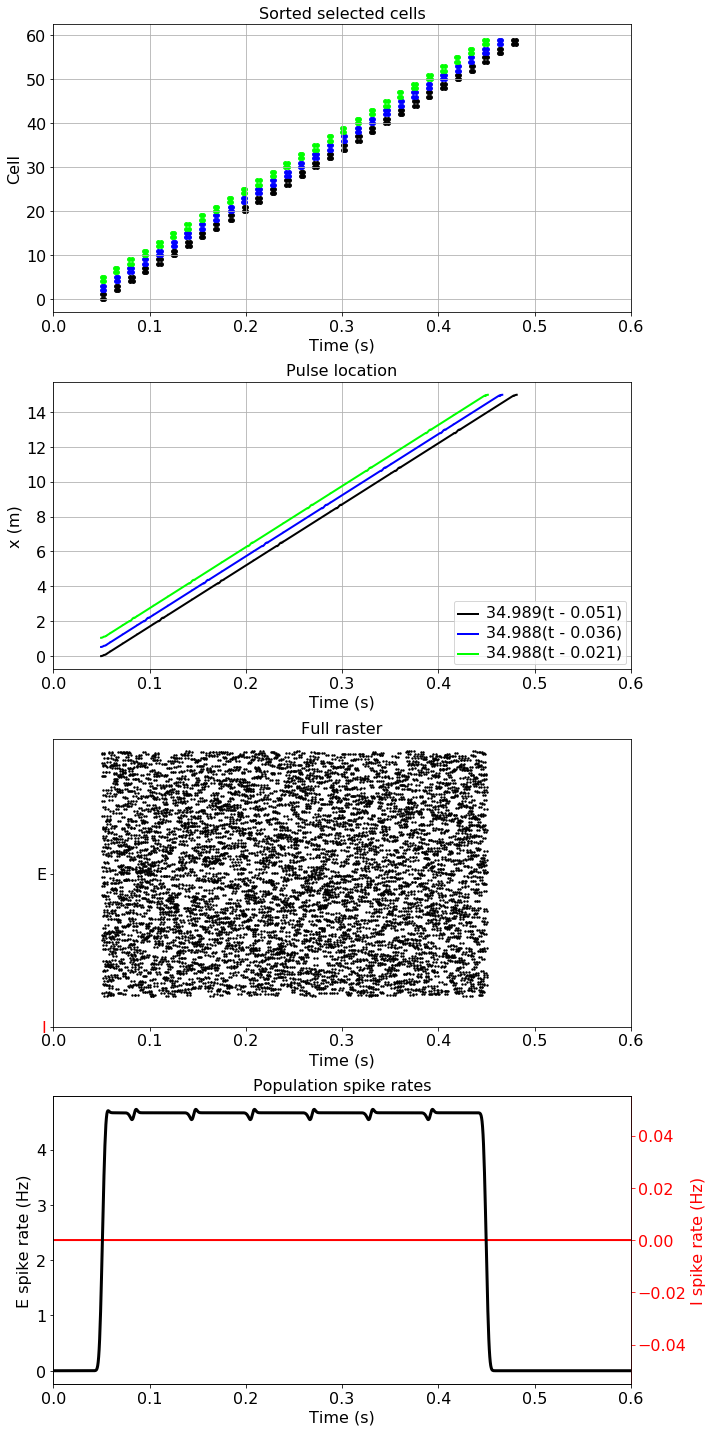

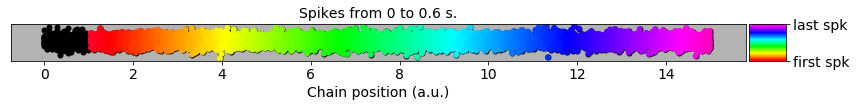

In [11]:
qk_plt(rslts, rslt_c, epoch=(0, .6))

# Auxiliary

## Speed control via recurrent inhibition strength

In [12]:
m = copy(M)
s = copy(S)

w_e_is = [0, .4e-6]
rslts = []
rslt_c = [(0, 1, 0), (0, .5, 0), (0, 0, 0)]

for w_e_i in w_e_is:
    m['W_E_I'] = w_e_i

    print('Running smln with W_E_I = {:.2f} uS/cm^2...'.format(w_e_i*1e6))
    
    t = np.arange(0, s['D_SMLN'], s['DT'])
    
    ## build ntwk
    ntwk = build_ntwk(m, s)
   
    # initialize external current array
    i_ext = np.zeros((len(t), m['N_E'] + m['N_I']))
    
    # add replay trigger
    i_ext += i_ext_trg(t, ntwk, m, s)
    
    # run smln
    clamp = Generic(
        v={0: cc([np.repeat(m['E_L_E'], m['N_E']), np.repeat(m['E_L_I'], m['N_I'])])}, spk={})
    rslt = ntwk.run(i_ext=i_ext, clamp=clamp, dt=s['DT'])
    
    # consolidate smln rslt
    rslt.ntwk = ntwk
    rslt.trg = s['TRG']
    
    rslt.m = m
    rslt.s = s
    
    rslts.append(rslt)

Running smln with W_E_I = 0.00 uS/cm^2...
Running smln with W_E_I = 0.40 uS/cm^2...


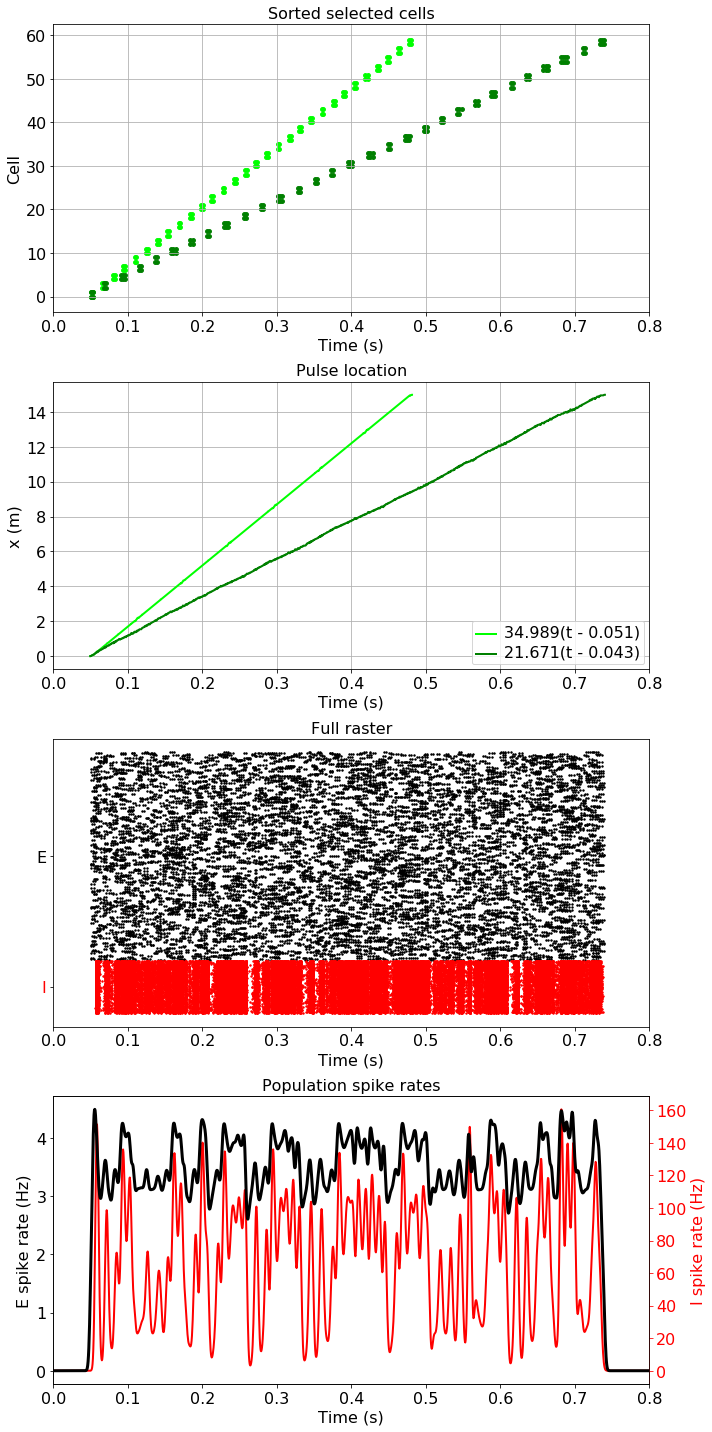

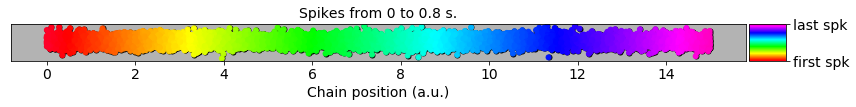

In [13]:
qk_plt(rslts, rslt_c, epoch=(0, .8))

## Speed control via excitatory drive to INH neurons

In [14]:
m = copy(M)
s = copy(S)

i_ext_i = [-2e-6, 0]
rslts = []
rslt_c = [(0, 1, 0), (0, .5, 0), (0, 0, 0)]

for i_ext_i_ in i_ext_i:

    print('Running smln with I_EXT_I = {:.2f} uA/cm^2...'.format(i_ext_i_*1e6))
    
    t = np.arange(0, s['D_SMLN'], s['DT'])
    
    ## build ntwk
    ntwk = build_ntwk(m, s)
   
    # initialize external current array
    i_ext = np.zeros((len(t), m['N_E'] + m['N_I']))
    
    # add replay trigger
    i_ext += i_ext_trg(t, ntwk, m, s)
    
    # add current input to INH units
    i_ext[:, -m['N_I']:] += i_ext_i_
    
    # run smln
    clamp = Generic(
        v={0: cc([np.repeat(m['E_L_E'], m['N_E']), np.repeat(m['E_L_I'], m['N_I'])])}, spk={})
    rslt = ntwk.run(i_ext=i_ext, clamp=clamp, dt=s['DT'])
    
    # consolidate smln rslt
    rslt.ntwk = ntwk
    rslt.trg = s['TRG']
    
    rslt.m = m
    rslt.s = s
    
    rslts.append(rslt)

Running smln with I_EXT_I = -2.00 uA/cm^2...
Running smln with I_EXT_I = 0.00 uA/cm^2...


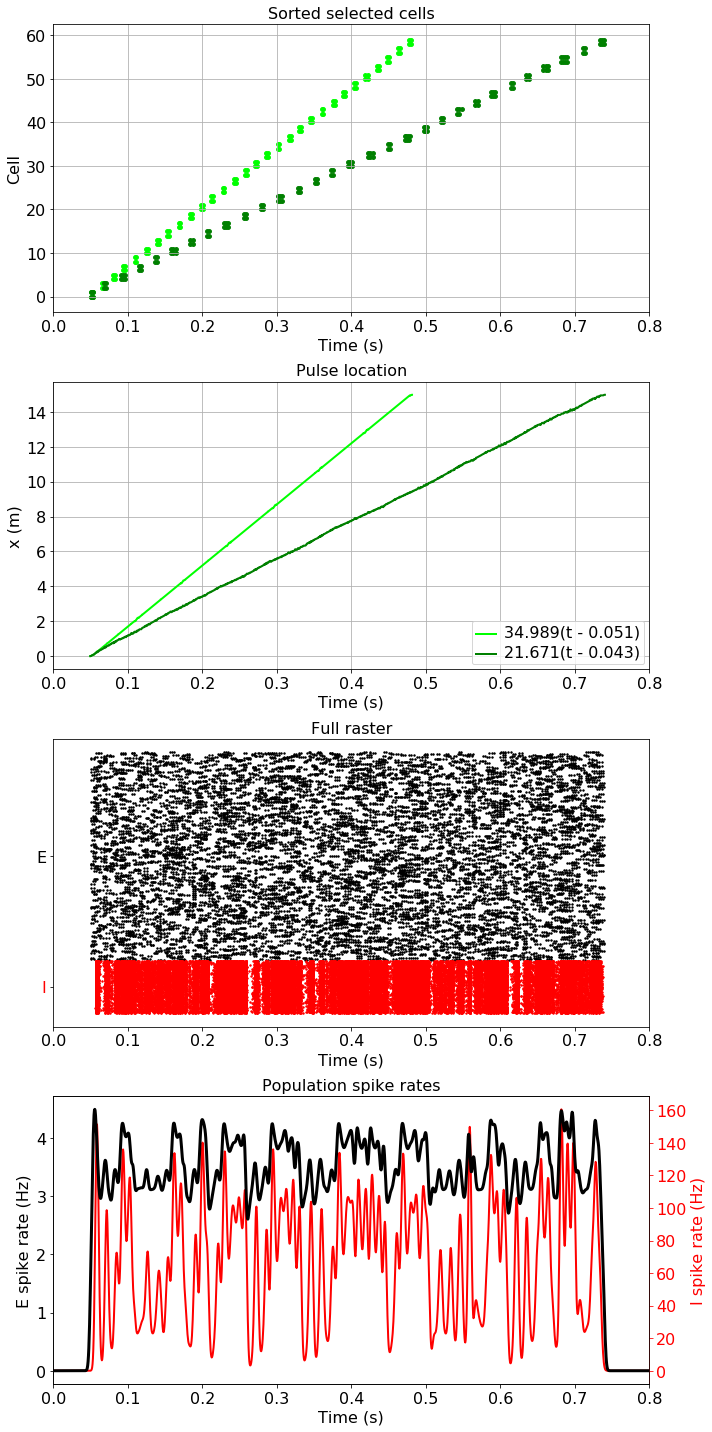

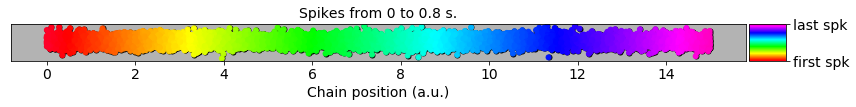

In [15]:
qk_plt(rslts, rslt_c, epoch=(0, .8))

## Test heterogeneous propagation speed

In [16]:
m = copy(M)
s = copy(S)

t2zone = [[], [(0, 15)], [(0, 7.5)], [(7.5, 15)]]
rslts = []
rslt_c = [(0, 0, 1), (0, 1, 0), (0, .5, 0), (0, 0, 0)]

for zone in t2zone:

    print('Running smln with ZONES {}...'.format(zone))
    
    t = np.arange(0, s['D_SMLN'], s['DT'])
    
    ## build ntwk
    ntwk = build_ntwk(m, s, e_i_zone=zone)

    # initialize external current array
    i_ext = np.zeros((len(t), m['N_E'] + m['N_I']))
    
    # add replay trigger
    i_ext += i_ext_trg(t, ntwk, m, s)

    # run smln
    clamp = Generic(
        v={0: cc([np.repeat(m['E_L_E'], m['N_E']), np.repeat(m['E_L_I'], m['N_I'])])}, spk={})
    rslt = ntwk.run(i_ext=i_ext, clamp=clamp, dt=s['DT'])
    
    # consolidate smln rslt
    rslt.ntwk = ntwk
    rslt.trg = s['TRG']
    
    rslt.m = m
    rslt.s = s
    
    rslts.append(rslt)

Running smln with ZONES []...
Running smln with ZONES [(0, 15)]...
Running smln with ZONES [(0, 7.5)]...
Running smln with ZONES [(7.5, 15)]...


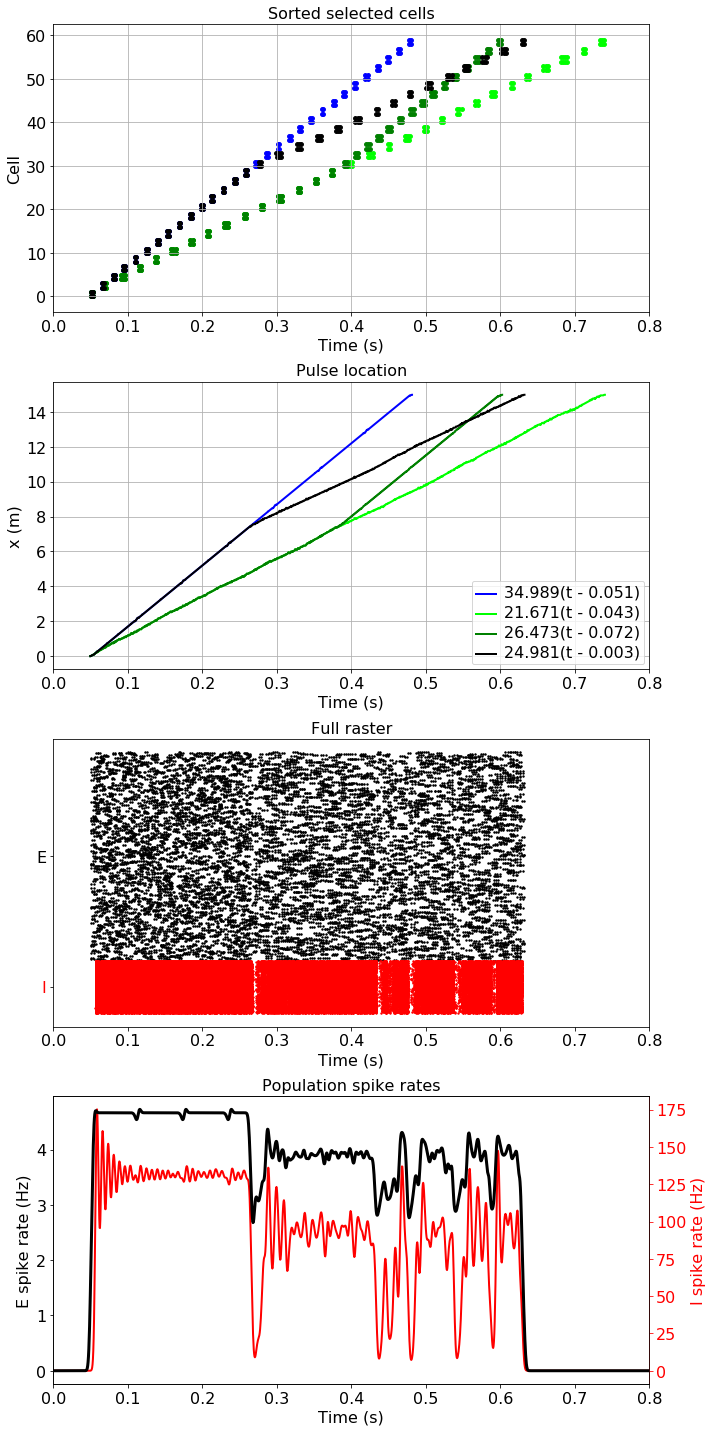

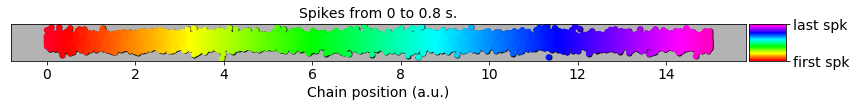

In [17]:
qk_plt(rslts, rslt_c, epoch=(0, .8))

# Connectivity

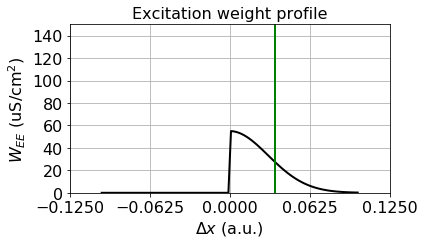

In [18]:
dx = np.linspace(-.1, .1, 100)
w = np.zeros(dx.shape)
mask_f = dx >= 0  # forward cxns
w[mask_f] = M['W_E_E'] * np.exp(-dx[mask_f]**2/(2*M['L_E_E_F']**2))
## set all weights below min weight th to 0
w[w < M['W_MIN_E_E']] = 0

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5), tight_layout=True)
ax.plot(dx, w*1e6, c='k', lw=2)
ax.axvline(M['DX'], c='g', lw=2)
ax.set_ylim(0, 150)
ax.set_xlabel(r'$\Delta x$ (a.u.)')
ax.set_ylabel(r'$W_{EE}$ (uS/cm$^2$)')
ax.set_title('Excitation weight profile')
ax.grid()
set_n_x_ticks(ax, 5)
set_font_size(ax, 16)